In [1]:
%env CUDA_VISIBLE_DEVICES=2
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

# from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('bmh')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=2


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))
    

def train_sampling_pattern(train_gen, n=14, loss_fn=F.l1_loss):
    bks = next(iter(train_gen))
    w = torch.zeros(320).cuda().float()
    w[160] = 1
    bbatch = 32
    w_list = []
    pbar = tqdm(range(n))
    for count in pbar:
        w = torch.autograd.Variable(w, requires_grad=True)
        for j in range(bks.shape[0] // bbatch):
            bbks = bks[bbatch*j:bbatch*(j+1)].cuda()
            bbgt = IFt(bbks).abs()
            recs = IFt(bbks * w).abs()
            loss = loss_fn(recs, bbgt)
            loss.backward()
        for i in torch.topk(w.grad, 320, largest=False).indices:
            if w[i] == 0: 
                w = w.detach()
                w[i] = 1.
                w_list.append(w.clone())
                pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                break
    return w_list

def test_sampling_pattern(sampling, val_gen, score_fn=F.l1_loss):
    bks = next(iter(val_gen))
    scores = []
    for j in tqdm(range(bks.shape[0])):
        bbks = bks[j:j+1].cuda()
        bbgt = IFt(bbks).abs()
        with torch.no_grad():
            recs = IFt(bbks * sampling).abs()
        scores.append(score_fn(recs[:, 220:-220, 60:-60], bbgt[:, 220:-220, 60:-60]).item())
    return scores

In [3]:
def t2i(x):
    x = x - x.min()
    x = x / x.max()
    x = x * 255.
    return x

def pt_ssim(pred, gt):
    from pytorch_msssim import ssim
    return ssim(t2i(pred)[None], t2i(gt)[None], win_size=11)

def ssim_score(pred, gt):
    from k_space_reconstruction.utils.metrics import ssim
    return ssim(t2i(pred).cpu().numpy(), t2i(gt).cpu().numpy())

def pt_msssim(pred, gt):
    from pytorch_msssim import ms_ssim
    return ms_ssim(t2i(pred)[None], t2i(gt)[None])

def pt_nmse(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    return torch.norm(gt - pred, p=2) ** 2 / torch.norm(gt, p=2) ** 2

def pt_psnr(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    maxval = gt.max()
    mse = torch.mean((pred - gt) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [4]:
np.random.seed(42)
torch.manual_seed(42)

train_datasets = {
    'PD1T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/train_PD_1T.h5', None),
    'PD3T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/train_PD_3T.h5', None),
    'PDFS1T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/train_PDFS_1T.h5', None),
    'PDFS3T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/train_PDFS_3T.h5', None),
}

val_datasets = {
    'PD1T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/val_PD_1T.h5', None),
    'PD3T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/val_PD_3T.h5', None),
    'PDFS1T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/val_PDFS_1T.h5', None),
    'PDFS3T': LegacyFastMRIh5Dataset('/home/a_razumov/small_datasets/fastMRIh5_split/val_PDFS_3T.h5', None),
}

train_generators = {k:torch.utils.data.DataLoader(v, batch_size=len(v), shuffle=True) for k,v in train_datasets.items()}
val_generators = {k:torch.utils.data.DataLoader(v, batch_size=len(v), shuffle=False) for k,v in val_datasets.items()}

In [5]:
train_dataset = train_datasets['PD3T']
val_dataset = val_datasets['PD3T']

train_generator = train_generators['PD3T']
val_generator = val_generators['PD3T']

In [6]:
ks = train_datasets['PD3T'][0]

In [7]:
ks.shape

torch.Size([640, 320])

# 5-fold validation x16

In [8]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(20)//2 : 320//2 + int(20)//2] = 1
fm = torch.ones(320).cuda().float()

fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, n=19, loss_fn=F.l1_loss)
    fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[18], vg, score_fn=pt_ssim),
        fastmri=test_sampling_pattern(fastmri_mask_x16, vg, score_fn=pt_ssim), 
        center=test_sampling_pattern(zm, vg, score_fn=pt_ssim),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in fold_scores.values()]
with open('fold_scores_l2.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

In [9]:
with open('fold_scores_l2.pkl', 'rb') as f: fold_scores = pickle.load(f)

In [10]:
import scipy

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-47.98684720289339, pvalue=1.1282519660101401e-06)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.426638,0.467216,0.473714
std,0.007083,0.007792,0.007812
min,0.420538,0.461055,0.467785
25%,0.421140,0.461446,0.468009
50%,0.425897,0.466263,0.472474
75%,0.427491,0.467037,0.473371
max,0.438125,0.480279,0.486933


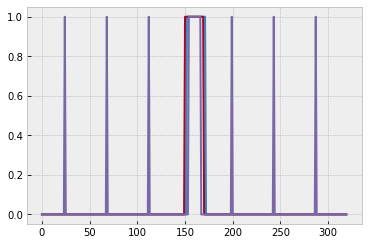

In [11]:
plt.plot(w_list[-1].data.cpu())
plt.plot(zm.data.cpu())
plt.plot(fastmri_mask_x16.data.cpu())
plt.show()

In [12]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(20)//2 : 320//2 + int(20)//2] = 1
fm = torch.ones(320).cuda().float()

fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, n=19, loss_fn=lambda x,y : -pt_psnr(x, y))
    fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[18], vg, score_fn=pt_ssim),
        fastmri=test_sampling_pattern(fastmri_mask_x16, vg, score_fn=pt_ssim), 
        center=test_sampling_pattern(zm, vg, score_fn=pt_ssim),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in fold_scores.values()]
with open('fold_scores_psnr.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

In [13]:
import scipy

with open('fold_scores_psnr.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-47.98684720289339, pvalue=1.1282519660101401e-06)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.433547,0.467216,0.473714
std,0.006909,0.007792,0.007812
min,0.427807,0.461055,0.467785
25%,0.428098,0.461446,0.468009
50%,0.432685,0.466263,0.472474
75%,0.434333,0.467037,0.473371
max,0.444813,0.480279,0.486933


In [14]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(20)//2 : 320//2 + int(20)//2] = 1
fm = torch.ones(320).cuda().float()

fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, n=19, loss_fn=lambda x,y : -pt_ssim(x, y))
    fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[18], vg, score_fn=pt_ssim),
        fastmri=test_sampling_pattern(fastmri_mask_x16, vg, score_fn=pt_ssim), 
        center=test_sampling_pattern(zm, vg, score_fn=pt_ssim),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in fold_scores.values()]
with open('fold_scores_ssim.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

In [15]:
import scipy

with open('fold_scores_ssim.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-3.65686188383289, pvalue=0.021640079477235372)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.434053,0.467216,0.468684
std,0.006879,0.007792,0.007784
min,0.428345,0.461055,0.463045
25%,0.428465,0.461446,0.463427
50%,0.433290,0.466263,0.466223
75%,0.434973,0.467037,0.468741
max,0.445190,0.480279,0.481983


In [16]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(20)//2 : 320//2 + int(20)//2] = 1
fm = torch.ones(320).cuda().float()

fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, n=19, loss_fn=lambda x,y : -pt_msssim(x, y))
    fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[18], vg, score_fn=pt_ssim),
        fastmri=test_sampling_pattern(fastmri_mask_x16, vg, score_fn=pt_ssim), 
        center=test_sampling_pattern(zm, vg, score_fn=pt_ssim),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in fold_scores.values()]
with open('fold_scores_msssim.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

In [17]:
import scipy

with open('fold_scores_msssim.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-11.243995622619245, pvalue=0.0003563755366608021)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.435708,0.467216,0.472808
std,0.006812,0.007792,0.008207
min,0.429938,0.461055,0.466266
25%,0.430732,0.461446,0.468009
50%,0.434838,0.466263,0.471097
75%,0.436070,0.467037,0.471737
max,0.446963,0.480279,0.486933


# 5-fold validation x8

In [29]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x8 = torch.tensor(EquispacedMaskFunc([0.04], [8])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(40)//2 : 320//2 + int(40)//2] = 1
fm = torch.ones(320).cuda().float()

fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, n=39, loss_fn=F.l1_loss)
    fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[-1], vg, score_fn=pt_ssim),
        fastmri=test_sampling_pattern(fastmri_mask_x8, vg, score_fn=pt_ssim), 
        center=test_sampling_pattern(zm, vg, score_fn=pt_ssim),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in fold_scores.values()]
with open('fold_scores_l2_x8.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

In [30]:
import scipy

with open('fold_scores_l2_x8.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-57.36459347746635, pvalue=5.529632110604527e-07)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.470528,0.576725,0.583744
std,0.006357,0.007931,0.007772
min,0.464331,0.570392,0.577465
25%,0.465569,0.572153,0.579560
50%,0.470177,0.574047,0.581145
75%,0.472262,0.576763,0.583471
max,0.480302,0.590269,0.597080


# 5-fold validation x5

In [38]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x5 = torch.tensor(EquispacedMaskFunc([0.04], [5])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(64)//2 : 320//2 + int(64)//2] = 1
fm = torch.ones(320).cuda().float()

fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, n=63, loss_fn=F.l1_loss)
    fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[-1], vg, score_fn=pt_ssim),
        fastmri=test_sampling_pattern(fastmri_mask_x5, vg, score_fn=pt_ssim), 
        center=test_sampling_pattern(zm, vg, score_fn=pt_ssim),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in fold_scores.values()]
with open('fold_scores_l2_x5.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

In [39]:
import scipy

with open('fold_scores_l2_x5.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-24.933966132959284, pvalue=1.5358296329315145e-05)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.530906,0.662424,0.670277
std,0.005730,0.007718,0.007062
min,0.524761,0.656544,0.665090
25%,0.526394,0.659034,0.666992
50%,0.530878,0.659239,0.667079
75%,0.533411,0.661421,0.669654
max,0.539088,0.675880,0.682572


# 5-fold validation x4

In [40]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x4 = torch.tensor(EquispacedMaskFunc([0.04], [4])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(80)//2 : 320//2 + int(80)//2] = 1
fm = torch.ones(320).cuda().float()

fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, n=79, loss_fn=F.l1_loss)
    fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[-1], vg, score_fn=pt_ssim),
        fastmri=test_sampling_pattern(fastmri_mask_x4, vg, score_fn=pt_ssim), 
        center=test_sampling_pattern(zm, vg, score_fn=pt_ssim),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in fold_scores.values()]
with open('fold_scores_l2_x4.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/2075 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

In [41]:
import scipy

with open('fold_scores_l2_x4.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-36.44284081410106, pvalue=3.384740933735797e-06)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.571783,0.705411,0.711708
std,0.005200,0.007118,0.006735
min,0.566963,0.700048,0.706585
25%,0.567915,0.702203,0.708699
50%,0.570459,0.702271,0.708703
75%,0.573785,0.704743,0.711151
max,0.579796,0.717791,0.723404


## Full train

In [43]:
w_list = train_sampling_pattern(train_generators['PD3T'], n=79, loss_fn=F.l1_loss)
torch.save(w_list, 'sampling_igs.pt')

  0%|          | 0/79 [00:00<?, ?it/s]

In [8]:
fastmri_mask_x4 = torch.tensor(EquispacedMaskFunc([0.04], [4])((640, 320))[0]).cuda().float()
zm = torch.zeros(320).cuda().float()
zm[320//2 - int(80)//2 : 320//2 + int(80)//2] = 1
fm = torch.ones(320).cuda().float()
w = torch.load('sampling_igs.pt')[-1]

In [9]:
w.sum(), zm.sum()

(tensor(80., device='cuda:0'), tensor(80., device='cuda:0'))

tensor(0.7192)
0.7346537865804029


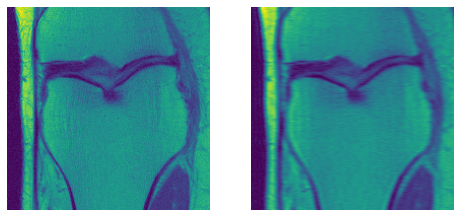

In [10]:
ks = train_dataset[323]
img = IFt(ks).abs()
_img = IFt(ks * w.cpu()).abs()

print(pt_ssim(_img[220:-220, 60:-60][None], img[220:-220, 60:-60][None]))
print(ssim_score(_img[220:-220, 60:-60][None], img[220:-220, 60:-60][None]))

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(img[220:-220, 60:-60])
plt.axis('off')

plt.subplot(122)
plt.imshow(_img[220:-220, 60:-60])
plt.axis('off')

plt.show()

tensor(0.7050)
0.7202899083976736


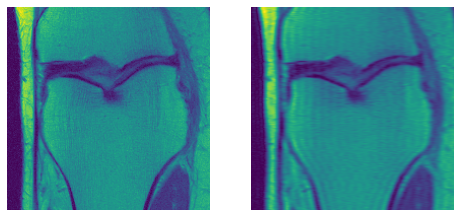

In [11]:
ks = train_dataset[323]
img = IFt(ks).abs()
_img = IFt(ks * zm.cpu()).abs()

print(pt_ssim(_img[220:-220, 60:-60][None], img[220:-220, 60:-60][None]))
print(ssim_score(_img[220:-220, 60:-60][None], img[220:-220, 60:-60][None]))

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(img[220:-220, 60:-60])
plt.axis('off')

plt.subplot(122)
plt.imshow(_img[220:-220, 60:-60])
plt.axis('off')

plt.show()

tensor(0.5671)
0.5486545220630374


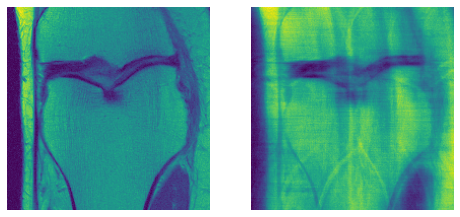

In [12]:
ks = train_dataset[323]
img = IFt(ks).abs()
_img = IFt(ks * fastmri_mask_x4.cpu()).abs()

print(pt_ssim(_img[220:-220, 60:-60][None], img[220:-220, 60:-60][None]))
print(ssim_score(_img[220:-220, 60:-60][None], img[220:-220, 60:-60][None]))

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(img[220:-220, 60:-60])
plt.axis('off')

plt.subplot(122)
plt.imshow(_img[220:-220, 60:-60])
plt.axis('off')

plt.show()

In [14]:
ssim_scores = dict(
    ours=test_sampling_pattern(w, val_generators['PD3T'], score_fn=pt_ssim),
    fastmri=test_sampling_pattern(fastmri_mask_x4, val_generators['PD3T'], score_fn=pt_ssim), 
    center=test_sampling_pattern(zm, val_generators['PD3T'], score_fn=pt_ssim),
)

psnr_scores = dict(
    ours=test_sampling_pattern(w, val_generators['PD3T'], score_fn=pt_psnr),
    fastmri=test_sampling_pattern(fastmri_mask_x4, val_generators['PD3T'], score_fn=pt_psnr), 
    center=test_sampling_pattern(zm, val_generators['PD3T'], score_fn=pt_psnr),
)

nmse_scores = dict(
    ours=test_sampling_pattern(w, val_generators['PD3T'], score_fn=pt_nmse),
    fastmri=test_sampling_pattern(fastmri_mask_x4, val_generators['PD3T'], score_fn=pt_nmse), 
    center=test_sampling_pattern(zm, val_generators['PD3T'], score_fn=pt_nmse),
)

print('SSIM')
print(pd.DataFrame.from_dict(ssim_scores).describe())
print('PSNR')
print(pd.DataFrame.from_dict(psnr_scores).describe())
print('NMSE')
print(pd.DataFrame.from_dict(nmse_scores).describe())

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 0/1992 [00:00<?, ?it/s]

SSIM
              ours      fastmri       center
count  1992.000000  1992.000000  1992.000000
mean      0.699558     0.564430     0.693210
std       0.102476     0.082127     0.101608
min       0.025568     0.132779     0.025254
25%       0.677009     0.527346     0.670491
50%       0.715555     0.561356     0.709001
75%       0.754154     0.603475     0.746588
max       0.914247     0.815776     0.909440
PSNR
              ours      fastmri       center
count  1992.000000  1992.000000  1992.000000
mean     26.860683    20.329746    26.849439
std       3.275443     3.314353     3.205168
min      10.184169    11.671541    10.100690
25%      25.198386    18.291992    25.265934
50%      26.970737    20.244328    26.891373
75%      28.854317    22.101372    28.850932
max      36.853035    35.257545    36.780609
NMSE
              ours      fastmri       center
count  1992.000000  1992.000000  1992.000000
mean      0.028792     0.103897     0.028694
std       0.051433     0.091302     0.05